
# Exploratory Data Analysis (EDA) for CIFAR-10


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import cifar10

# Load Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Dataset shape
print("🔹 Training data shape:", x_train.shape)
print("🔹 Testing data shape:", x_test.shape)
print("🔹 Number of classes:", len(np.unique(y_train)))




🔹 Training data shape: (50000, 32, 32, 3)
🔹 Testing data shape: (10000, 32, 32, 3)
🔹 Number of classes: 10


/tmp/ipython-input-2-895688933.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_flat, palette="viridis")


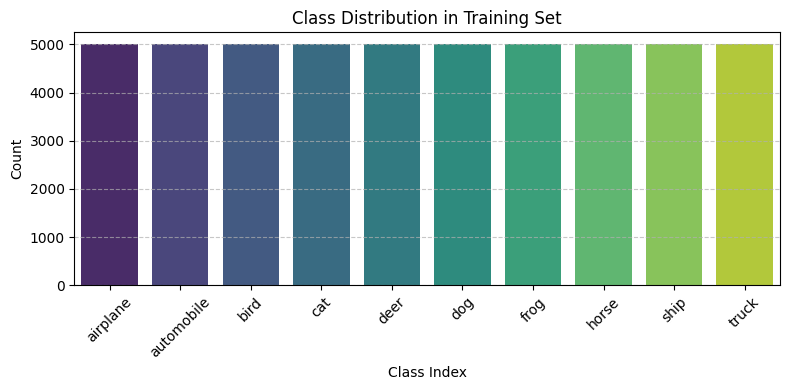

In [2]:
# Flatten y for distribution
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

# Class distribution (train)
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train_flat, palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.xticks(ticks=range(10), labels=class_names, rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



/tmp/ipython-input-3-340419125.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


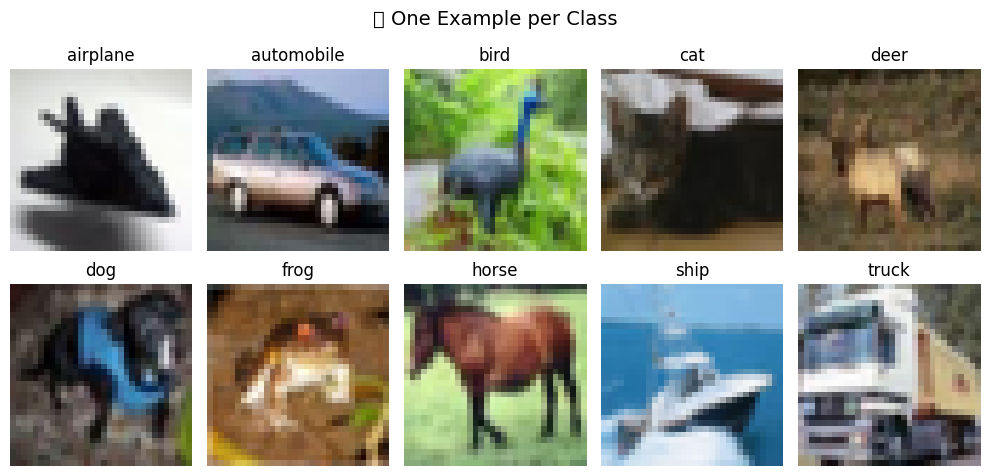

In [3]:
# Show some sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    idx = np.where(y_train_flat == i)[0][0]
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle("🔍 One Example per Class", fontsize=14)
plt.tight_layout()
plt.show()

# Preprocess

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

IMG_SIZE = 96
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


In [5]:


# Normalize & resize in pipeline
def preprocess(img, label):
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.one_hot(label[0], 10)

# Train/Test pipeline
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).shuffle(5000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Build Efficient MobileNetV2 Model

In [6]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze for first phase

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
history = model.fit(train_ds, validation_data=test_ds, epochs=15)


Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - accuracy: 0.6157 - loss: 1.1223 - val_accuracy: 0.7807 - val_loss: 0.6495
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7362 - loss: 0.7670 - val_accuracy: 0.7867 - val_loss: 0.6183
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7507 - loss: 0.7189 - val_accuracy: 0.7966 - val_loss: 0.5922
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7558 - loss: 0.6966 - val_accuracy: 0.7944 - val_loss: 0.5953
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.7647 - loss: 0.6786 - val_accuracy: 0.7944 - val_loss: 0.6105
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.7646 - loss: 0.6754 - val_accuracy: 0.8040 - val_loss: 0.5666
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7693 - loss: 0.6582 - val_accuracy: 0.7965 - val_loss: 0.5858
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.7738 -

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Freeze most layers

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - accuracy: 0.6225 - loss: 1.9001 - val_accuracy: 0.7986 - val_loss: 0.6538
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.7268 - loss: 1.0257 - val_accuracy: 0.8128 - val_loss: 0.6222
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7582 - loss: 0.8093 - val_accuracy: 0.8195 - val_loss: 0.5710
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7773 - loss: 0.6827 - val_accuracy: 0.8253 - val_loss: 0.5396
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.8004 - loss: 0.6050 - val_accuracy: 0.8323 - val_loss: 0.5085


# Plot Accuracy and Loss

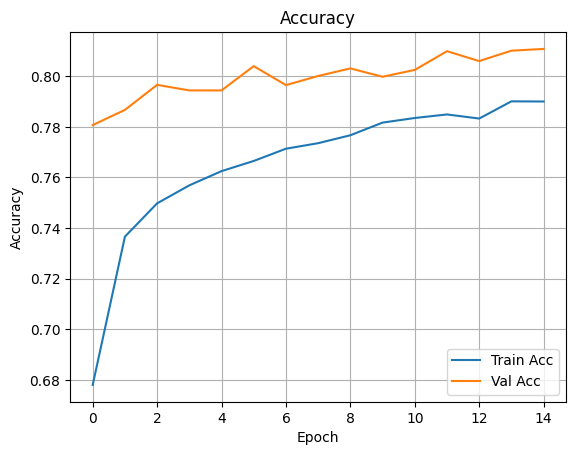

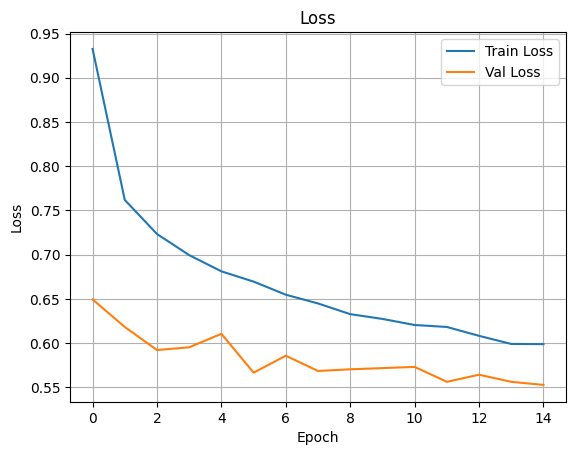

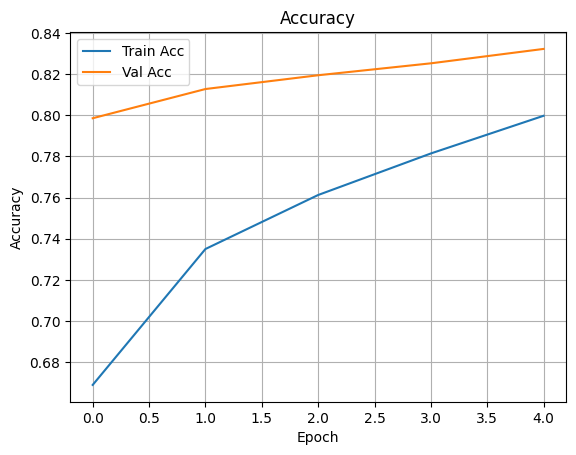

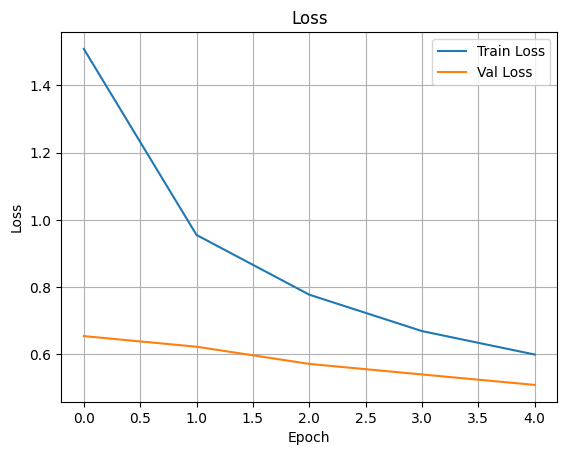

In [9]:
def plot_history(h):
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.plot(h.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(h.history['loss'], label='Train Loss')
    plt.plot(h.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)
plot_history(history_finetune)


# Evaluate


In [10]:
loss, acc = model.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {acc * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8326 - loss: 0.5145
✅ Final Test Accuracy: 83.23%


# Predict One Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


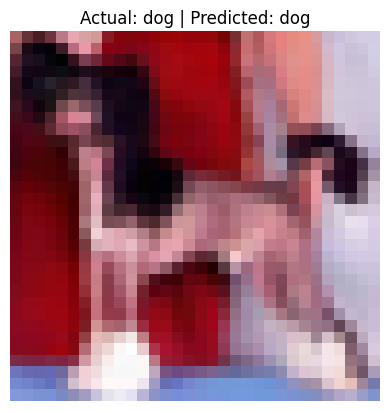

In [23]:
import random

i = random.randint(0, len(x_test)-1)
img = x_test[i]
true = class_names[y_test[i][0]]

img_resized = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
img_resized = tf.expand_dims(img_resized / 255.0, axis=0)

pred = model.predict(img_resized)
predicted = class_names[np.argmax(pred)]

plt.imshow(img)
plt.title(f"Actual: {true} | Predicted: {predicted}")
plt.axis('off')
plt.show()


# Save Model

In [12]:
model.save("mobilenetv2_cifar10_model.h5")


# Predictive System

In [15]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load model
model = tf.keras.models.load_model("mobilenetv2_cifar10_model.h5")

# Class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Predict function
def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((96, 96))
    plt.imshow(img)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


('horse', np.float32(0.98806703))

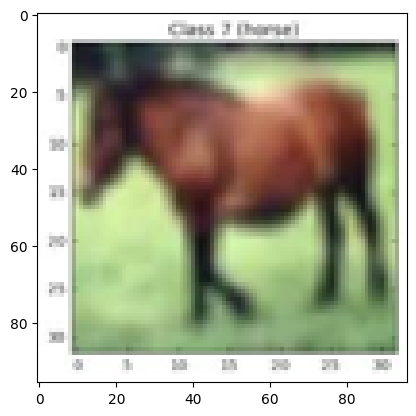

In [16]:
predict_image('/content/images (10).jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


('deer', np.float32(0.53291816))

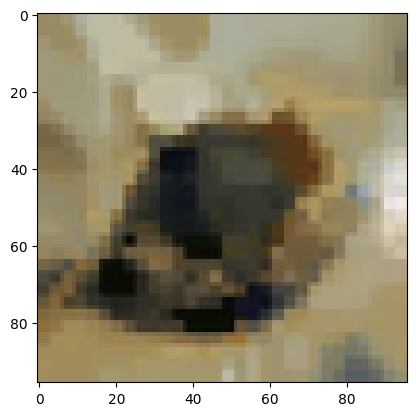

In [21]:
predict_image('/content/images (11).jpeg')